In [2]:
%load_ext autoreload
%autoreload 2
from kernel import KernelLogisticRegression
import torch
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-v0_8-whitegrid')

GitHub Link to Kernel.py File: [https://github.com/jjr2024/github_jjr2024.github.io/blob/main/posts/kernel-machines/kernel.py](https://github.com/jjr2024/github_jjr2024.github.io/blob/main/posts/kernel-machines/kernel.py)

## Introduction

In this blog post, I implement and test the kernel logistic regression model. I experiment with different hyperparameter values on different types of data, including moon-shaped data. I find that while high gamma values can be useful to fit nonlinear patterns in data, they can also promote overfitting.

## Part A: Implementation

In the below code, we define two functions. **classification_data** generates some number (n_points) of observations of a given difficulty (noise) with a specified number of features (p_dims). **plot_classification** data is a function to visualize our generated data.

In [3]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    # X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    X = X - X.mean(dim = 0, keepdim = True)
    return X, y

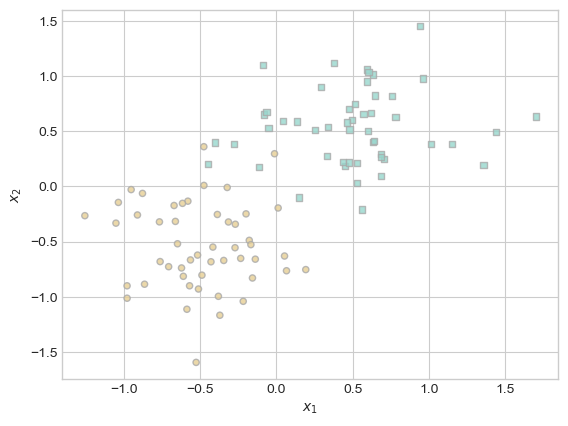

In [4]:
def plot_classification_data(X, y, ax):
    assert X.shape[1] == 2, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -1, vmax = 2, alpha = 0.8, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = classification_data(n_points = 100, noise = 0.4)
plot_classification_data(X, y, ax)

Below, we define our kernel that we will use throughout this post. It comes from the assignment instructions and is a very standard positive-definite kernel function.

In [5]:
def rbf_kernel(X_1, X_2, gamma):
    return torch.exp(-gamma*torch.cdist(X_1, X_2)**2)

Below, we train our model on the generated data to ensure that the implementation in kernel.py is correct (or at least able to run).

In [6]:
KR = KernelLogisticRegression(rbf_kernel, lam = 0.01, gamma = 0.1)
KR.fit(X, y, m_epochs = 500000, lr = 0.0001)
lossvec = KR.lossvec
lossvec

[tensor(2.2461),
 tensor(2.2442),
 tensor(2.2423),
 tensor(2.2405),
 tensor(2.2386),
 tensor(2.2367),
 tensor(2.2348),
 tensor(2.2329),
 tensor(2.2310),
 tensor(2.2292),
 tensor(2.2273),
 tensor(2.2254),
 tensor(2.2235),
 tensor(2.2216),
 tensor(2.2197),
 tensor(2.2179),
 tensor(2.2160),
 tensor(2.2141),
 tensor(2.2122),
 tensor(2.2103),
 tensor(2.2085),
 tensor(2.2066),
 tensor(2.2047),
 tensor(2.2028),
 tensor(2.2010),
 tensor(2.1991),
 tensor(2.1972),
 tensor(2.1953),
 tensor(2.1935),
 tensor(2.1916),
 tensor(2.1897),
 tensor(2.1878),
 tensor(2.1860),
 tensor(2.1841),
 tensor(2.1822),
 tensor(2.1803),
 tensor(2.1785),
 tensor(2.1766),
 tensor(2.1747),
 tensor(2.1729),
 tensor(2.1710),
 tensor(2.1691),
 tensor(2.1672),
 tensor(2.1654),
 tensor(2.1635),
 tensor(2.1616),
 tensor(2.1598),
 tensor(2.1579),
 tensor(2.1560),
 tensor(2.1542),
 tensor(2.1523),
 tensor(2.1504),
 tensor(2.1486),
 tensor(2.1467),
 tensor(2.1448),
 tensor(2.1430),
 tensor(2.1411),
 tensor(2.1393),
 tensor(2.1374

Below we print the first and last items in the loss vector. We see the latter is dramatically smaller than the former, which indicates our kernel machine was at least partially successful.

In [7]:
print(lossvec[0], lossvec[len(lossvec)-1])

tensor(2.2461) tensor(0.3400)


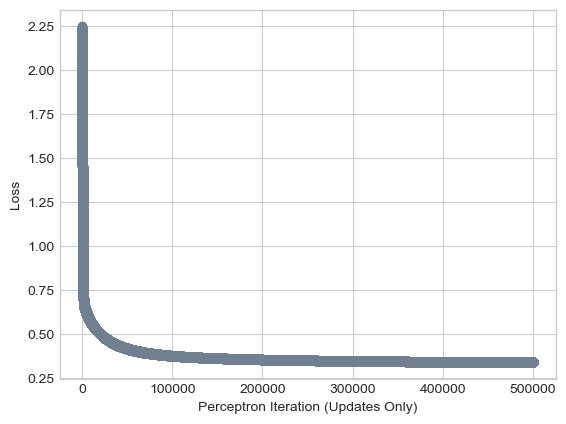

In [8]:
plt.plot(lossvec, color = "slategrey")
plt.scatter(torch.arange(len(lossvec)), lossvec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "Loss")

The above visualization shows our model successfully converges to some relatively low loss.

In [9]:
print(f"Proportion of Weights Above 0.01: {(1.0*(KR.a > 0.01)).mean()}" )
print(f"Proportion of Weights Above 0.000001: {(1.0*(KR.a > 0.000001)).mean()}")

Proportion of Weights Above 0.01: 0.3100000023841858
Proportion of Weights Above 0.000001: 0.36000001430511475


The above shows that only a small portion of our weights (~30%) are distinguishable from zero.

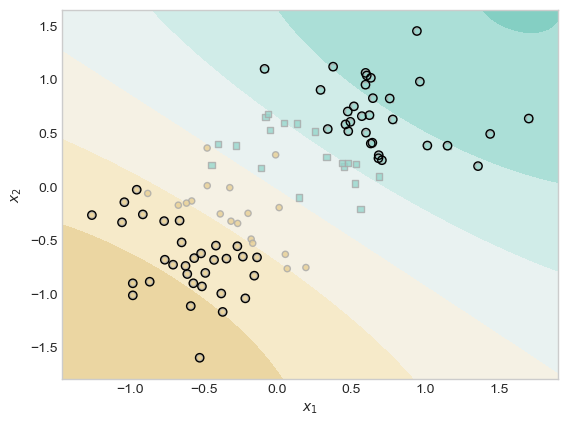

In [10]:
ix = torch.abs(KR.a) > 0.001

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_, recompute_kernel = True)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")
# ax.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")

The above shows scores with the training data. The black-outlined data points are those whose weights are distinguishable from 0 (i.e.., if KR.a is over 0.001). The color gradient shows the decision boundaries of our kernel machine. We can see that our model does a relatively good job of separating the two categories of observations.

## Part B: Experiments

### Experiment 1: Large Lambda 

Below is an experiment in which we set lambda to an extremely high value. We find that with lam = 10.15, the kernel logistic regression learns to a set of weights in which only one weight is distinguishable from zero if we assume "distinguishable from zero" means the weight is above 0.001.

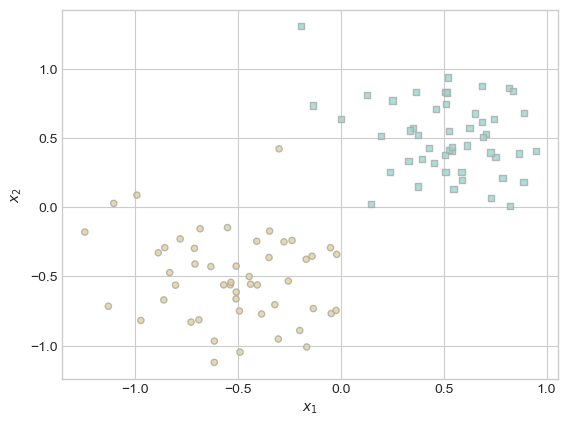

In [29]:
fig, ax = plt.subplots(1, 1)
X, y = classification_data(n_points = 100, noise = 0.3)
plot_classification_data(X, y, ax)

In [30]:
KR = KernelLogisticRegression(rbf_kernel, lam = 10, gamma = 0.1)
KR.fit(X, y, m_epochs = 50000, lr = 0.0001)
lossvec = KR.lossvec
lossvec

[tensor(50.5874),
 tensor(49.5199),
 tensor(48.4966),
 tensor(47.4461),
 tensor(46.4471),
 tensor(45.4384),
 tensor(44.4501),
 tensor(43.4904),
 tensor(42.5340),
 tensor(41.6012),
 tensor(40.6418),
 tensor(39.7207),
 tensor(38.7570),
 tensor(37.8609),
 tensor(36.8913),
 tensor(36.0238),
 tensor(35.0720),
 tensor(34.2305),
 tensor(33.3050),
 tensor(32.4559),
 tensor(31.5480),
 tensor(30.7434),
 tensor(29.8854),
 tensor(29.0985),
 tensor(28.2606),
 tensor(27.4565),
 tensor(26.6645),
 tensor(25.8942),
 tensor(25.1283),
 tensor(24.3984),
 tensor(23.6604),
 tensor(22.9387),
 tensor(22.2169),
 tensor(21.5226),
 tensor(20.8359),
 tensor(20.1697),
 tensor(19.5277),
 tensor(18.8991),
 tensor(18.3055),
 tensor(17.6751),
 tensor(17.1218),
 tensor(16.5091),
 tensor(15.9750),
 tensor(15.3769),
 tensor(14.8653),
 tensor(14.2609),
 tensor(13.7816),
 tensor(13.2040),
 tensor(12.7586),
 tensor(12.1916),
 tensor(11.7591),
 tensor(11.2060),
 tensor(10.8095),
 tensor(10.3091),
 tensor(9.9178),
 tensor(9.4

In [31]:
print(f"Number of Weights Above 0.001: {(1.0*(torch.abs(KR.a) > 0.001)).mean()*len(KR.a)}" )

Number of Weights Above 0.001: 1.0


We see above that the number of weights with an absolute value above 0.001 is just 1.

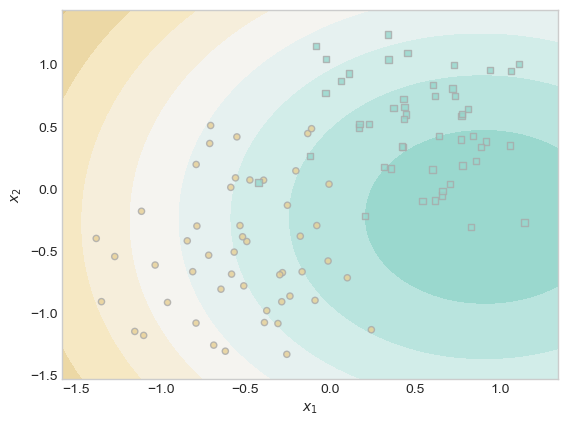

In [14]:
ix = torch.abs(KR.a) > 0.001

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_, recompute_kernel = True)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")
# ax.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")

We see above that the kernel machine learned some bizzare decision boundaries because of the high lambda value. It's learned to categorize points near 1.0, -0.25 as the turquoise category, and as points go farther from that center, they are more likely to be categorized as the beige category.

### Experiment 2: Changing Gamma

In this experiment, I set gamma to a very high value (gamma = 6) and observe that the decision boundaries become less neat and more wiggly, likely in reaction to specific observations and therefore a probable indication of overfitting.

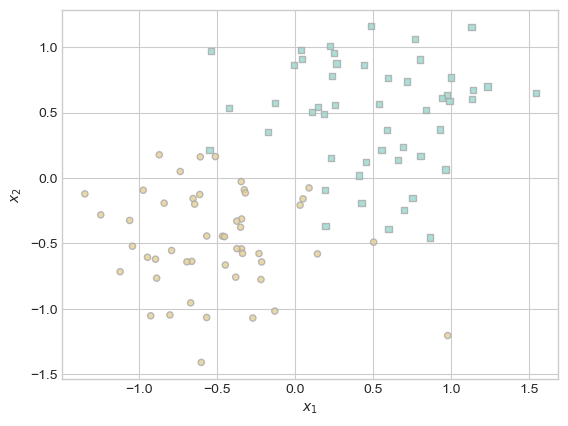

In [15]:
fig, ax = plt.subplots(1, 1)
X, y = classification_data(n_points = 100, noise = 0.4)
plot_classification_data(X, y, ax)

In [16]:
KR = KernelLogisticRegression(rbf_kernel, lam = 0.1, gamma = 6)
KR.fit(X, y, m_epochs = 50000, lr = 0.0001)
lossvec = KR.lossvec

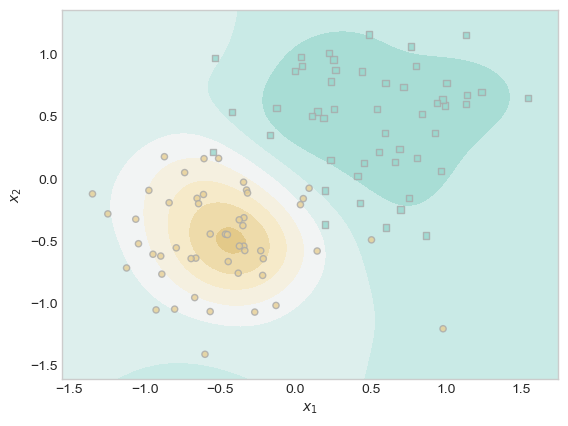

In [17]:
ix = torch.abs(KR.a) > 0.001

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_, recompute_kernel = True)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")
# ax.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")

Above, we see that our decision boundaries have become wigglier--they aren't curved lines or circles anymore. They're bending in reaction to specific observations, probably an indication of overfitting.

### Experiment 3: Nonlinear Patterns in Data

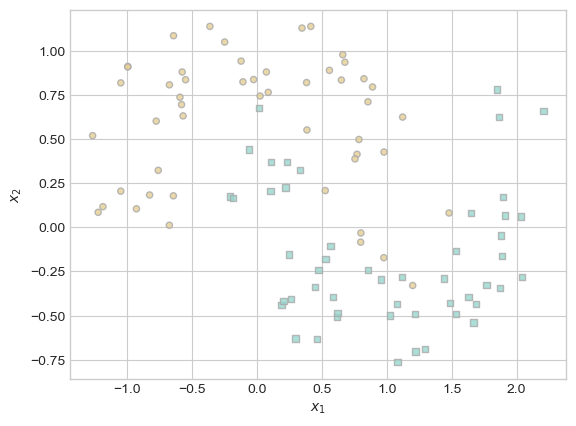

In [18]:


X, y = make_moons(n_samples=100, noise=0.2)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
fig, ax = plt.subplots(1, 1)
plot_classification_data(X, y, ax)

In [19]:
KR = KernelLogisticRegression(rbf_kernel, lam = 0.1, gamma = 2)
KR.fit(X, y, m_epochs = 500000, lr = 0.0001)
lossvec = KR.lossvec

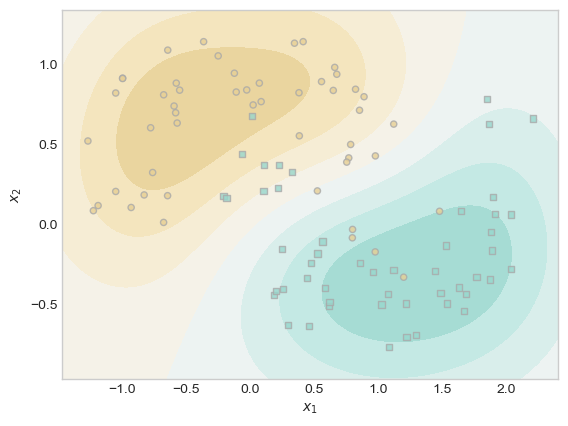

In [20]:
ix = torch.abs(KR.a) > 0.001

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_, recompute_kernel = True)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")
# ax.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")

We see above that while the model didn't perfectly capture the nonlinear pattern in the data, it did a decent job and has mostly correct decision boundaries. A higher gamma (not displayed) promotes a better fit but could also lead to less simple decision boundaries and overfitting.

## Part B: Overfitting

In this section, I conduct an experiment to show that a very high gamma value can promote overfitting.

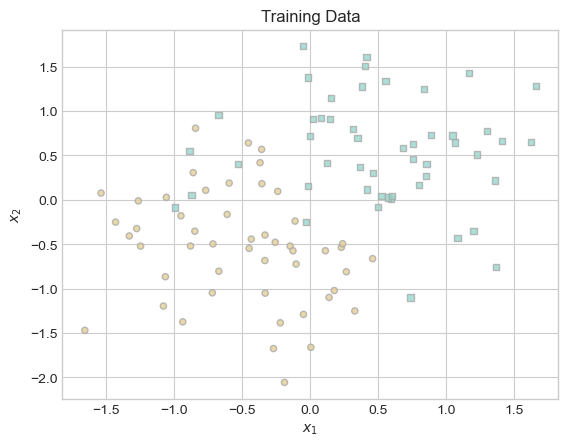

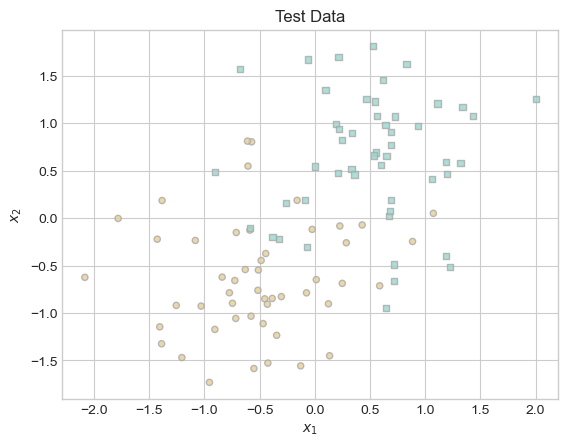

In [21]:
fig, ax1 = plt.subplots(1, 1)
fig, ax2 = plt.subplots(1, 1)
observations = 100
difficulty = 0.6
X_train, y_train = classification_data(n_points = observations, noise = difficulty)
X_test, y_test = classification_data(n_points = observations, noise = difficulty)
ax1.set_title('Training Data')
ax2.set_title('Test Data')

plot_classification_data(X_train, y_train, ax1)

plot_classification_data(X_test, y_test, ax2)

In [22]:
KR = KernelLogisticRegression(rbf_kernel, lam = 0.1, gamma = 0.2)
KR.fit(X_train, y_train, m_epochs = 500000, lr = 0.0001)
lossvec = KR.lossvec

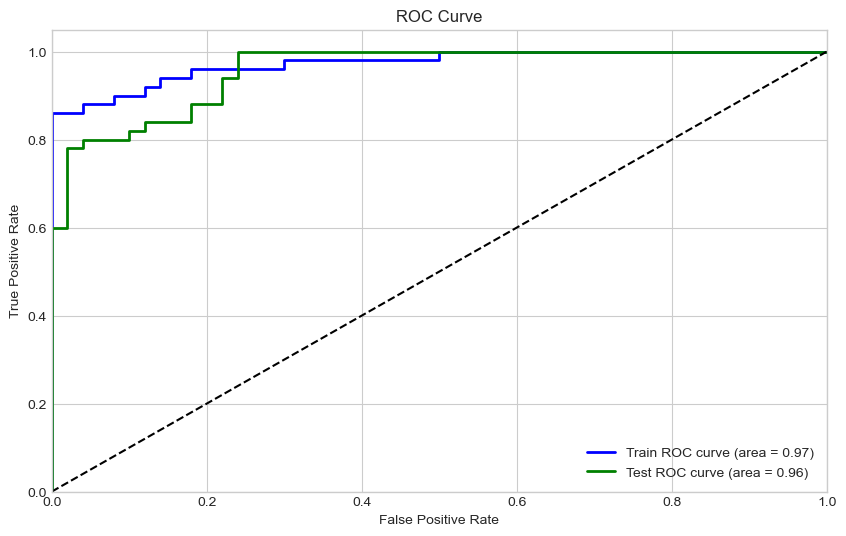

In [23]:
train_scores = KR.score(X_train, recompute_kernel=True)
test_scores = KR.score(X_test, recompute_kernel=True)

# Compute ROC curve and AUC for training data
fpr_train, tpr_train, _ = roc_curve(y_train, train_scores)
roc_auc_train = auc(fpr_train, tpr_train)

# Same as above but for test data
fpr_test, tpr_test, _ = roc_curve(y_test, test_scores)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (area = {roc_auc_test:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot([0,1], [0,1], color = "black", linestyle = '--') #This black line shows what the ROC curve would be with "no skill" or random guessing 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

This first graph with ROC curves shows that with a normal gamma (0.2) leads to pretty similar ROC curves on the train and test sets.

In [24]:
KR_high_gamma = KernelLogisticRegression(rbf_kernel, lam = 0.1, gamma = 12)
KR_high_gamma.fit(X_train, y_train, m_epochs = 500000, lr = 0.0001)
lossvec = KR_high_gamma.lossvec

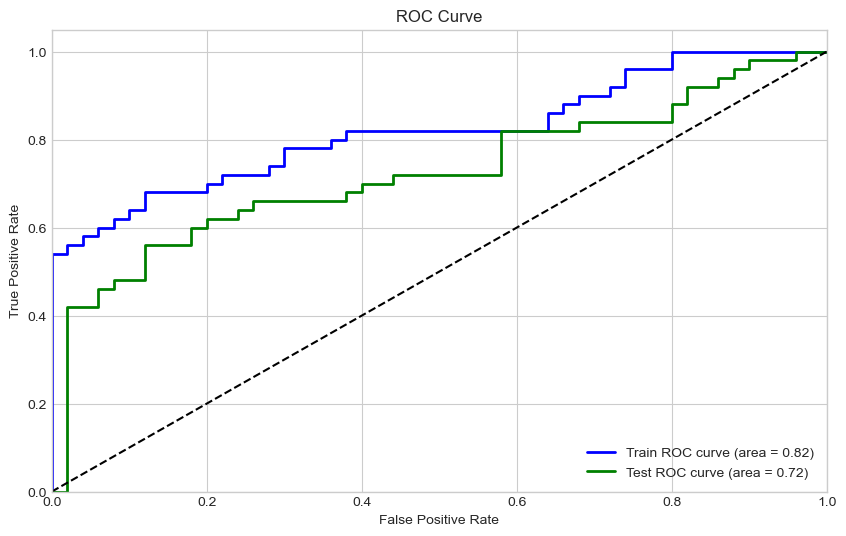

In [25]:
train_scores = KR_high_gamma.score(X_train, recompute_kernel=True)
test_scores = KR_high_gamma.score(X_test, recompute_kernel=True)

# Compute ROC curve and AUC for training data
fpr_train, tpr_train, _ = roc_curve(y_train, train_scores)
roc_auc_train = auc(fpr_train, tpr_train)

# Same as above but for test data
fpr_test, tpr_test, _ = roc_curve(y_test, test_scores)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (area = {roc_auc_test:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot([0,1], [0,1], color = "black", linestyle = '--') #This black line shows what the ROC curve would be with "no skill" or random guessing 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

This second graph with ROC curves shows that with a very high gamma (12) see a dramatic deterioration in the ROC curve on the test set.

## Conclusion

In this post, I implemented and tested the kernel logistic regression model. I experimented with high values for lambda and high values for gamma. I also experimented on data with nonlinear patterns and showed the impact of a too-high gamma on ROC curves. The takeaways from these experiments were: 
* a too-high lambda can lead to a small number of weights having an outsized impact on the model's predictions
* a too-high gamma can lead to overfitting
* a high gamma can help find nonlinear patterns in data

In writing this post, I synthesized what I learned from the blog posts on the perceptron, logistic regression, and Newton's method blog posts. It was a valuable learning experience to navigate this blog post, which had less instruction than previous posts. I learned to get a bit more experimental in my approach to writing the Python code. I ran into an issue in which my scores were too high, leading to the sigmoid maxing out at 1 and causing my losses to be NaNs. I ended up just initializing the weights as smaller values by dividing the initial random values by 10. Maybe this isn't conceptually sound, but it worked.  